In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
st = time.time()

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
# url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
# output = 'pancreas.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata_all = sc.read('pancreas.h5ad')

In [8]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[adata.obs[condition_key].isin(['Pancreas CelSeq2'])]
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_conditions, source_adata

(['Pancreas CelSeq2'],
 View of AnnData object with n_obs × n_vars = 2426 × 1000
     obs: 'batch', 'study', 'cell_type', 'size_factors')

In [9]:
adata_tasks = ['Pancreas CelSeq2','Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2','Pancreas inDrop'] #'Pancreas CelSeq2',

In [10]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [11]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='rehearsal',
)

rehearsal is happening!
 |███████-------------| 35.2%  - val_loss: 748.2772827148 - val_recon_loss: 736.9939270020 - val_kl_loss: 12.8952775002 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |███████-------------| 36.6%  - val_loss: 743.2768859863 - val_recon_loss: 731.8010253906 - val_kl_loss: 12.6108164787 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 161


In [12]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

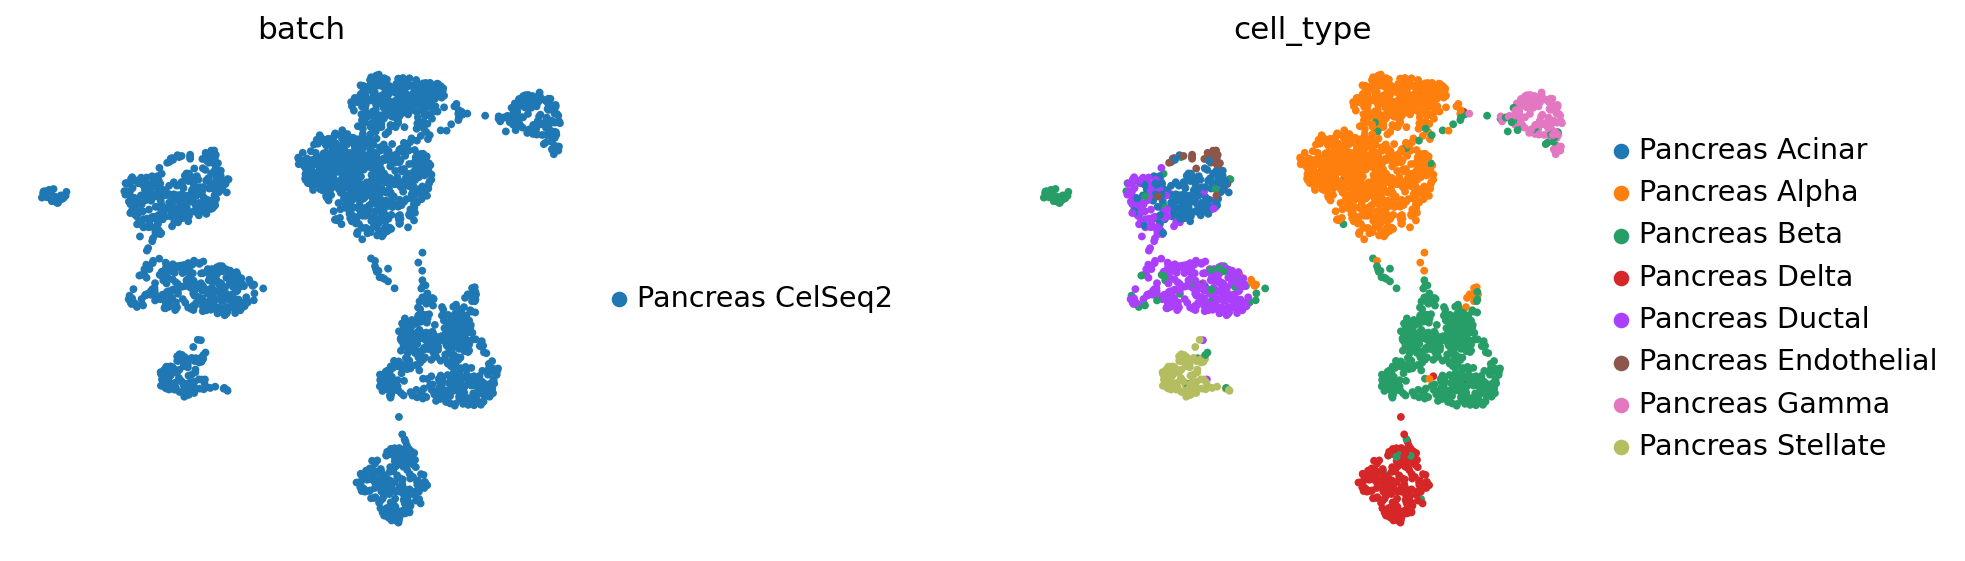

In [13]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [14]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [15]:
new_tasks = adata_tasks[1:]
for ID in range(len(new_tasks)): #adata_tasks[1:] if you wanna skip the first item, , start=1
    print('ID BEFORE:', ID)
    ID +=1
    print('ID:', ID)
    
    for ID_past in range(ID):
        print('ID_past:', ID_past)
        task_i = adata[adata.obs[condition_key].isin([adata_tasks[ID_past],adata_tasks[ID]])]
        print('adata_tasks[ID_past,ID]:', [adata_tasks[ID_past],adata_tasks[ID]])
        print('task_i:', task_i)
        new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                     learning_approach = 'rehearsal',
                                                     model=ref_path)
        new_trvae.train(
        n_epochs=surgery_epochs,
        alpha_epoch_anneal=200,
        early_stopping_kwargs=early_stopping_kwargs,
        #ID=ID,
        weight_decay=0,
        learning_approach = 'rehearsal'
        )

        ref_path = 'reference_model/'#+ str (ID)
        new_trvae.save(ref_path, overwrite=True)
    

ID BEFORE: 0
ID: 1
ID_past: 0
adata_tasks[ID_past,ID]: ['Pancreas CelSeq2', 'Pancreas CelSeq']
task_i: View of AnnData object with n_obs × n_vars = 3697 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 

rehearsal is happening!
 |███-----------------| 15.6%  - val_loss: 675.4925740560 - val_recon_loss: 666.7857055664 - val_kl_loss: 21.5484288534 - val_mmd_loss: 0.4107386271
ADJUSTED LR
 |████----------------| 21.4%  - val_loss: 675.9678548177 - val_recon_loss: 664.7603759766 - val_kl_loss: 20.2655080160 - val_mmd_loss: 0.4667549133
ADJUSTED LR
 |████----------------| 22.8%  - val_loss: 676.0765177409 - val_recon_loss: 664.2452799479 - val_kl_loss: 20.1498883565 - val_mmd_loss: 0.4465465546
Stopping early: 

 |██------------------| 12.2%  - val_loss: 408.7798461914 - val_recon_loss: 401.0308113098 - val_kl_loss: 22.9335777760 - val_mmd_loss: 0.8689579964
ADJUSTED LR
 |██------------------| 13.6%  - val_loss: 407.2221221924 - val_recon_loss: 398.6662597656 - val_kl_loss: 22.7016837597 - val_mmd_loss: 0.9507982731
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 46
ID_past: 2
adata_tasks[ID_past,ID]: ['Pancreas Fluidigm C1', 'Pancreas inDrop']
task_i: View of AnnData object with n_obs × n_vars = 9023 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Lay

In [16]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [17]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

AxisArrays with keys: 

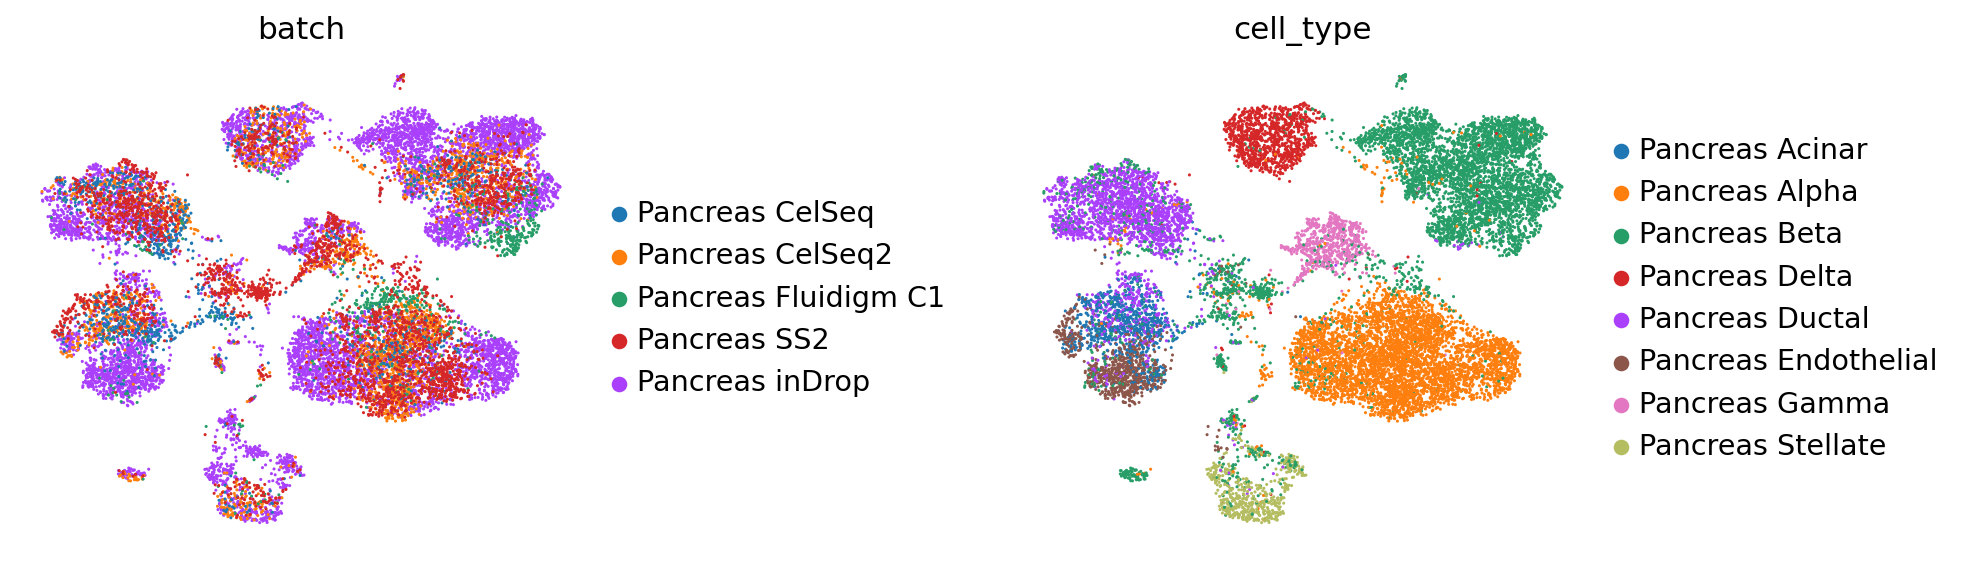

In [18]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [19]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:14:39


In [20]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_rehearsal

0.8419137670991846

In [21]:
sc.tl.umap(full_latent)
Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_rehearsal

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.771066
Pancreas Alpha                0.849421
Pancreas Beta                 0.804699
Pancreas Delta                0.833848
Pancreas Ductal               0.810704
Pancreas Endothelial          0.782155
Pancreas Gamma                0.815187
Pancreas Stellate             0.795578


0.8078323366284063

In [22]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_rehearsal

0.6269718110561371

In [23]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_rehearsal

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.5963678968951377


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9575655470148468


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8359286842699165


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.9647172547124215


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8175252768415984


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.728337236533958


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.9351432880844646


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.8319517709118313


0.8334421194080218

In [24]:
pcr_rehearsal=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_rehearsal

0.02870146673652502